### Assignment 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import patsy
import warnings
from sklearn.base import BaseEstimator
import statsmodels.formula.api as smf
import scipy
import hdmpy
warnings.simplefilter('ignore')
np.random.seed(1234)

file = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/darfur.csv"
data = pd.read_csv(file)
print(data.shape)

# Preprocessing: take out village fixed effects and run basic linear analysis

# Get rid of village fixed effects
peacefactorR = smf.ols(formula="peacefactor ~ village", data=data).fit().resid
directlyharmedR = smf.ols(formula="directlyharmed ~ village", data=data).fit().resid
femaleR = smf.ols(formula="female ~ village", data=data).fit().resid
ageR = smf.ols(formula="age ~ village", data=data).fit().resid
farmerR = smf.ols(formula="farmer_dar ~ village", data=data).fit().resid
herderR = smf.ols(formula="herder_dar ~ village", data=data).fit().resid
pastvotedR = smf.ols(formula="pastvoted ~ village", data=data).fit().resid
hhsizeR = smf.ols(formula="hhsize_darfur ~ village", data=data).fit().resid

# Preliminary linear model analysis
# Here we are clustering standard errors at the village level

# Estimating the effect of the treatment, controlling linearly for other factors
model1 = smf.ols(formula="peacefactorR ~ directlyharmedR + femaleR + ageR + farmerR + herderR + pastvotedR + hhsizeR",
                 data=data).fit(cov_type='cluster', cov_kwds={'groups': data['village']})
print(model1.summary())

# OLS model that predicts the outcome from controls
model2 = smf.ols(formula="peacefactorR ~ femaleR + ageR + farmerR + herderR + pastvotedR + hhsizeR",
                 data=data).fit(cov_type='cluster', cov_kwds={'groups': data['village']})
print(model2.summary())

# OLS model that predicts the treatment from controls
model3 = smf.ols(formula="directlyharmedR ~ femaleR + ageR + farmerR + herderR + pastvotedR + hhsizeR",
                 data=data).fit(cov_type='cluster', cov_kwds={'groups': data['village']})
print(model3.summary())

(1276, 14)
                            OLS Regression Results                            
Dep. Variable:           peacefactorR   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     25.44
Date:                Wed, 26 Feb 2025   Prob (F-statistic):           1.23e-29
Time:                        21:46:10   Log-Likelihood:                -5.2404
No. Observations:                1276   AIC:                             26.48
Df Residuals:                    1268   BIC:                             67.69
Df Model:                           7                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -8.509e-16   4.

In [2]:
import hdmpy


class RLasso(BaseEstimator):

    def __init__(self, *, post=True):
        self.post = post

    def fit(self, X, y):
        self.rlasso_ = hdmpy.rlasso(X, y, post=self.post)
        return self

    def predict(self, X):
        return np.array(X) @ np.array(self.rlasso_.est['beta']).flatten() + np.array(self.rlasso_.est['intercept'])


def lasso_model():
    return RLasso(post=False)

Z = np.column_stack((femaleR, ageR, farmerR, herderR, pastvotedR, hhsizeR))
Z = pd.DataFrame(Z, columns=['femaleR', 'ageR', 'farmerR', 'herderR', 'pastvotedR', 'hhsizeR'])
# Interactions of 3 degrees
controls = patsy.dmatrix('0 + (femaleR + ageR + farmerR + herderR + pastvotedR + hhsizeR)**3',
                         Z, return_type='dataframe')

resY = peacefactorR - lasso_model().fit(controls, peacefactorR).predict(controls)
resD = directlyharmedR - lasso_model().fit(controls, directlyharmedR).predict(controls)
print(("Controls explain the following fraction of variance of Outcome",
       1 - np.var(resY) / np.var(peacefactorR)))
print(("Controls explain the following fraction of variance of Treatment",
       1 - np.var(resD) / np.var(directlyharmedR)))

dml_data = pd.DataFrame({'resY': resY, 'resD': resD, 'village': data['village']})
dml_model = smf.ols(formula="resY ~ resD", data=dml_data).fit(cov_type='cluster',
                                                              cov_kwds={'groups': dml_data['village']})
print(dml_model.summary())

('Controls explain the following fraction of variance of Outcome', 0.12510805487928756)
('Controls explain the following fraction of variance of Treatment', 0.011984238217663812)
                            OLS Regression Results                            
Dep. Variable:                   resY   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     16.87
Date:                Wed, 26 Feb 2025   Prob (F-statistic):           4.69e-05
Time:                        21:46:10   Log-Likelihood:                -11.916
No. Observations:                1276   AIC:                             27.83
Df Residuals:                    1274   BIC:                             38.14
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std er

a.)  

The estimate of the causal effect of the treatment is 0.0973 and the CI is [0.051, 0.144]. The only control factors that were statistically significant at the 95% level in the second model were femaleR and ageR. The only control factor that was statistically significant at the 95% level in the third model was herderR .The estimate of the causal effect in the double lasso case is 0.1003 and the CI is [0.052, 0.148]. The result from double lasso is very similar to the one obtained from the first OLS regression, as is the confidence interval.  

absolute value of the bias: 0.03244444888924153


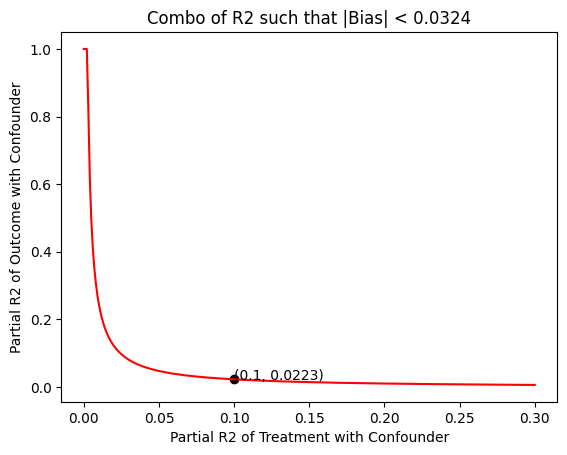

In [3]:
# Main estimate
beta = dml_model.params[1]

# Hypothetical values of partial R2s
R2_YC = 0.135
R2_DC = 0.018

# Elements of the bias equation
kappa = (R2_YC * R2_DC) / (1 - R2_DC)
variance_ratio = np.mean(dml_model.resid**2) / np.mean(resD**2)

# Compute square bias
BiasSq = kappa * variance_ratio

# Compute absolute value of the bias
print("absolute value of the bias:", np.sqrt(BiasSq))

# Plotting
gridR2_DC = np.arange(0, 0.301, 0.001)
gridR2_YC = kappa * (1 - gridR2_DC) / gridR2_DC
gridR2_YC = np.where(gridR2_YC > 1, 1, gridR2_YC)

# point where X= 0.1 
plt.plot(0.1, kappa * (1 - 0.1) / 0.1, 'o', color='black')
# put coordinates on plot
plt.text(0.1, kappa * (1 - 0.1) / 0.1, f'({0.1}, {np.round(kappa * (1 - 0.1) / 0.1, decimals=4)})')
# plot the curve
plt.plot(gridR2_DC, gridR2_YC, color='red')
plt.xlabel('Partial R2 of Treatment with Confounder')
plt.ylabel('Partial R2 of Outcome with Confounder')
plt.title(f'Combo of R2 such that |Bias| < {np.round(np.sqrt(BiasSq), decimals=4)}')
plt.show()

b.) 
  
The absolute value of the bias such a confounder may cause is 0.0324. Subtracting this from the lower bound of the CI of the double lasso model (0.052 - 0.0324) gives 0.0196, which is still positive. 

From the plot above, we can see that if the R-square for the treatment that the unobserved confounder further explains was 0.1, the R-square of the outcome should be approximately 0.02, so that the unobserved confounder can lead to the same amount of bias.


In [4]:
# packaging the bias analysis with some automated functions
# We now automate the DML process and pass the estimates to functions to automate the sensitivity analysis. This is done in the R package sensmakr, which does not exist in python.
def dml(X, D, y, modely, modeld, *, nfolds, classifier=False, cluster=True, clu=None):
    '''
    DML for the Partially Linear Model setting with cross-fitting

    Input
    -----
    X: the controls
    D: the treatment
    y: the outcome
    modely: the ML model for predicting the outcome y
    modeld: the ML model for predicting the treatment D
    nfolds: the number of folds in cross-fitting
    classifier: bool, whether the modeld is a classifier or a regressor

    clu: df column to cluster by
    cluster: bool, whether to use clustered standard errors

    Output
    ------
    point: the point estimate of the treatment effect of D on y
    stderr: the standard error of the treatment effect
    yhat: the cross-fitted predictions for the outcome y
    Dhat: the cross-fitted predictions for the treatment D
    resy: the outcome residuals
    resD: the treatment residuals
    epsilon: the final residual-on-residual OLS regression residual
    '''

    if nfolds > 1:
        cv = KFold(n_splits=nfolds, shuffle=True, random_state=123)  # shuffled k-folds
        yhat = cross_val_predict(modely, X, y, cv=cv, n_jobs=-1)  # out-of-fold predictions for y
        # out-of-fold predictions for D
        # use predict or predict_proba dependent on classifier or regressor for D
        if classifier:
            Dhat = cross_val_predict(modeld, X, D, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
        else:
            Dhat = cross_val_predict(modeld, X, D, cv=cv, n_jobs=-1)
    elif nfolds == -1:
        yhat = modely.fit(X, y).predict(X)
        if classifier:
            Dhat = modeld.fit(X, D).predict_proba(X)
        else:
            Dhat = modeld.fit(X, D).predict(X)

    # calculate outcome and treatment residuals
    resy = y - yhat
    resD = D - Dhat

    if cluster:
        # final stage ols clustered
        dml_data = pd.DataFrame({'resY': resY, 'resD': resD, 'cluster': clu})
    else:
        # final stage ols nonclustered
        dml_data = pd.DataFrame({'resY': resY, 'resD': resD})

    if cluster:
        # clustered standard errors
        ols_mod = smf.ols(formula='resY ~ 1 + resD', data=dml_data)
        ols_mod = ols_mod.fit(cov_type='cluster', cov_kwds={"groups": dml_data['cluster']})
    else:
        # regular ols
        ols_mod = smf.ols(formula='resY ~ 1 + resD', data=dml_data).fit()

    point = ols_mod.params[1]
    stderr = ols_mod.bse[1]
    epsilon = ols_mod.resid

    return point, stderr, yhat, Dhat, resy, resD, epsilon

def summary(point, stderr, yhat, Dhat, resy, resD, epsilon, X, D, y, *, name):
    '''
    Convenience summary function that takes the results of the DML function
    and summarizes several estimation quantities and performance metrics.
    '''
    return pd.DataFrame({'estimate': point,  # point estimate
                         'stderr': stderr,  # standard error
                         'lower': point - 1.96 * stderr,  # lower end of 95% confidence interval
                         'upper': point + 1.96 * stderr,  # upper end of 95% confidence interval
                         'rmse y': np.sqrt(np.mean(resy**2)),  # RMSE of model that predicts outcome y
                         'rmse D': np.sqrt(np.mean(resD**2))  # RMSE of model that predicts treatment D
                         }, index=[name])
    
def dml_sensitivity_bounds_single(res, eta_ysq, eta_asq, inds=None, return_stderr=False):
    ''' Sensitivity analysis, specialized for the partially linear DML moment
    E[(yres - theta * Tres) * Tres]. `est` is a `LinearDML` estimator fitted
    with `cache_values=True` so that residuals are being stored after fitting.

    Input
    -----
    res : tuple (yres, Tres)
        outcome and treatment residuals from the DML procedure
    eta_ysq : float
        posited partial R^2 for the outcome, that the unobserved confounder explains
    eta_asq : float
        posited partial R^2 for the treatment, that the unobserved confounder explains
    inds : list of int or None, optional (default=None)
        subset of samples to use for this analysis; useful for sub-population analysis
    return_stderr : bool, optional (default=False)
        whether to return standard errors for the lower and upper bound

    Returns
    -------
    lower : lower bound of confidence set
    lower_stderr : standard error for the lower bound (not returned if `return_stderr=False`)
    upper : upper bound of confidence set
    upper_stderr : standard error for the upper bound (not returned if `return_stderr=False`)
    '''
    if inds is None:
        inds = np.arange(res[0].shape[0])
    yres, Tres = res
    yres, Tres = yres[inds], Tres[inds]
    nusq = np.mean(Tres ** 2)
    theta = np.mean(yres * Tres) / nusq
    sigmasq = np.mean((yres - Tres * theta)**2)
    S = np.sqrt(sigmasq / nusq)
    Casq = eta_asq / (1 - eta_asq)
    Cgsq = eta_ysq
    error = S * np.sqrt(Casq * Cgsq)

    if not return_stderr:
        return theta - error, theta + error

    psi_theta = (yres - Tres * theta) * Tres / nusq
    psi_sigmasq = (yres - Tres * theta)**2 - sigmasq
    psi_nusq = Tres**2 - nusq

    phi_plus = psi_theta
    phi_plus += (np.sqrt(Casq * Cgsq) / (2 * S)) * (-(sigmasq / (nusq**2)) * psi_nusq + (1 / nusq) * psi_sigmasq)
    stderr_plus = np.sqrt(np.mean(phi_plus**2) / phi_plus.shape[0])

    phi_minus = psi_theta
    phi_minus -= (np.sqrt(Casq * Cgsq) / (2 * S)) * (-(sigmasq / (nusq**2)) * psi_nusq + (1 / nusq) * psi_sigmasq)
    stderr_minus = np.sqrt(np.mean(phi_minus**2) / phi_minus.shape[0])
    return theta - error, stderr_minus, theta + error, stderr_plus

# If we want reduce the uncertainty from sample splitting, we can re-run our nfolds cross-fitting and aggregate with the median estimates. With 10 folds as above, there shouldn't be too much variance anyway, but we employ the following aggregation procedure anyway

def dml_sensitivity_bounds(res_list, eta_ysq, eta_asq, alpha=None, inds=None):
    ''' Sensitivity analysis, specialized for the partially linear DML moment
    E[(yres - theta * Tres) * Tres]. `est` is a `LinearDML` estimator fitted
    with `cache_values=True` so that residuals are being stored after fitting.

    Input
    -----
    res_list : list of tuples (yres, Tres), or single tuple (yres, Tres)
        list of (outcome and treatment residuals from the DML procedure) on different
        random cross-fitting folds
    eta_ysq : float
        posited partial R^2 for the outcome, that the unobserved confounder explains
    eta_asq : float
        posited partial R^2 for the treatment, that the unobserved confounder explains
    alpha : float or None, optional (default=None)
        confidence level for confidence interval; if None, no uncertainty is incoprorated
    inds : list of int or None, optional (default=None)
        subset of samples to use for this analysis; useful for sub-population analysis

    Returns
    -------
    lower : lower bound of confidence set, incorporating uncertainty
    upper : upper bound of confidence set, incorporating uncertainty
    '''
    if not isinstance(res_list, list):
        res_list = [res_list]

    if alpha is None:
        lower, upper = zip(*[dml_sensitivity_bounds_single(res, eta_ysq, eta_asq, inds=inds, return_stderr=False)
                             for res in res_list])
        return np.median(lower), np.median(upper)
    else:
        lower, std_lower, upper, std_upper = zip(*[dml_sensitivity_bounds_single(res, eta_ysq, eta_asq,
                                                                                 inds=inds, return_stderr=True)
                                                   for res in res_list])
        std_lower = np.array(std_lower)
        std_upper = np.array(std_upper)
        lower = np.median(lower)
        lower -= scipy.stats.norm.ppf(1 - alpha / 2) * np.sqrt(np.median(std_lower**2) + np.var(lower))
        upper = np.median(upper)
        upper += scipy.stats.norm.ppf(1 - alpha / 2) * np.sqrt(np.median(std_upper**2) + np.var(upper))
        return lower, upper


def dml_sensitivity_contours(res_list, y_upper, a_upper, alpha=None, inds=None):
    ''' Specialized for linear DML. Sensitivity bounds contour plots based on a many trained doubly robust
    average moment models. If `alpha` is float, incorporates sampling uncertainty
    at the `alpha` level. Sensitivity parameter `eta_ysq` ranges in `[0, y_upper]`
    and parameter `eta_asq` ranges in `[0, a_upper]`.

    Input
    -----
    res_list : list of tuples (yres, Tres), or single tuple (yres, Tres)
        list of (outcome and treatment residuals from the DML procedure) on different
        random cross-fitting folds
    y_upper : float
        upper bound on posited partial R^2 for the outcome, that the unobserved confounder explains
    a_upper : float
        upper bound posited partial R^2 for the treatment, that the unobserved confounder explains
    alpha : float or None, optional (default=None)
        confidence level for confidence interval; if None, no uncertainty is incoprorated
    inds : list of int or None, optional (default=None)
        subset of samples to use for this analysis; useful for sub-population analysis

    Returns
    -------
    X, Y, Zlower, Zupper: contour plot arrays for the lower and upper bound of the confidence set
    '''
    xlist = np.linspace(0, a_upper, 100)
    ylist = np.linspace(0, y_upper, 100)
    X, Y = np.meshgrid(xlist, ylist)
    Zlower = np.zeros(X.shape)
    Zupper = np.zeros(X.shape)
    for itx in np.arange(X.shape[1]):
        for ity in np.arange(X.shape[0]):
            l, u = dml_sensitivity_bounds(res_list, Y[ity, itx], X[ity, itx], alpha=alpha, inds=inds)
            Zlower[ity, itx] = l
            Zupper[ity, itx] = u

    return X, Y, Zlower, Zupper

result_no_uncertainty = dml_sensitivity_bounds((resY, resD), R2_YC, R2_DC)
print("No uncertainty:", result_no_uncertainty)

result_with_uncertainty = dml_sensitivity_bounds((resY, resD), R2_YC, R2_DC, alpha=0.05)
print("With uncertainty:", result_with_uncertainty)

# Now we find the largest possible R2_DC that would make the bounds cross zero
R2_DC_largest = R2_DC
while dml_sensitivity_bounds((resY, resD), R2_YC, R2_DC_largest, alpha=0.05)[0] > 0:
    R2_DC_largest += 0.000001
print("Largest R2_DC:", R2_DC_largest)
print("Bounds with largest R2_DC:", dml_sensitivity_bounds((resY, resD), R2_YC, R2_DC_largest, alpha=0.05))

No uncertainty: (0.06789199924405459, 0.13278089702253765)
With uncertainty: (0.023034680259482576, 0.1775960026935741)
Largest R2_DC: 0.05087100000003287
Bounds with largest R2_DC: (-3.542817515467256e-07, 0.20063131319969985)


Incorporating uncertainty does not overturn the results.  The largest Rsquared of the treatment needed to overturn the results is 0.05087100000003287. 


### Assignment 2

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
import scipy.stats
import warnings
from sklearn.base import BaseEstimator, clone
from sklearn.base import TransformerMixin
from formulaic import Formula
warnings.simplefilter('ignore')
import os
os.environ["PYTHONWARNINGS"] = "ignore"
np.random.seed(1234)

file = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/401k.csv"
data_all = pd.read_csv(file)
data_bottom = data_all.loc[data_all['inc'] < data_all['inc'].quantile(0.25)].copy()
data_top = data_all.loc[data_all['inc'] > data_all['inc'].quantile(0.75)].copy()

class FormulaTransformer(TransformerMixin, BaseEstimator):

    def __init__(self, formula, array=False):
        self.formula = formula
        self.array = array

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        df = Formula(self.formula).get_model_matrix(X)
        if self.array:
            return df.values
        return df
    
transformer = FormulaTransformer("0 + poly(age, degree=6, raw=True) + poly(inc, degree=8, raw=True) "
                                 "+ poly(educ, degree=4, raw=True) + poly(fsize, degree=2, raw=True) "
                                 "+ male + marr + twoearn + db + pira + hown", array=True)

descs = ["all data", "bottom quartile of income", "top quartile of income"]
def dml(X, Z, D, y, modely, modeld, modelz, *, nfolds, classifier=False):
    '''
    DML for the Partially Linear Model setting with cross-fitting

    Input
    -----
    X: the controls
    Z: the instrument
    D: the treatment
    y: the outcome
    modely: the ML model for predicting the outcome y
    modeld: the ML model for predicting the treatment D
    modelz: the ML model for predicting the instrument Z
    nfolds: the number of folds in cross-fitting
    classifier: bool, whether the modeld is a classifier or a regressor

    Output
    ------
    point: the point estimate of the treatment effect of D on y
    stderr: the standard error of the treatment effect
    yhat: the cross-fitted predictions for the outcome y
    Dhat: the cross-fitted predictions for the treatment D
    Zhat: the cross-fitted predictions for the instrument Z
    resy: the outcome residuals
    resD: the treatment residuals
    resZ: the instrument residuals
    epsilon: the final residual-on-residual OLS regression residual
    '''
    cv = KFold(n_splits=nfolds, shuffle=True, random_state=123)  # shuffled k-folds
    yhat = cross_val_predict(modely, X, y, cv=cv, n_jobs=-1)  # out-of-fold predictions for y
    # out-of-fold predictions for D
    # use predict or predict_proba dependent on classifier or regressor for D
    if classifier:
        Dhat = cross_val_predict(modeld, X, D, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
        Zhat = cross_val_predict(modelz, X, Z, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
    else:
        Dhat = cross_val_predict(modeld, X, D, cv=cv, n_jobs=-1)
        Zhat = cross_val_predict(modelz, X, Z, cv=cv, n_jobs=-1)
    # calculate outcome and treatment residuals
    resy = y - yhat
    resD = D - Dhat
    resZ = Z - Zhat
    # final stage ols based point estimate and standard error
    point = np.mean(resy * resZ) / np.mean(resD * resZ)
    epsilon = resy - point * resD
    var = np.mean(epsilon**2 * resZ**2) / np.mean(resD * resZ)**2
    stderr = np.sqrt(var / X.shape[0])
    return point, stderr, yhat, Dhat, Zhat, resy, resD, resZ, epsilon


def iiv(X, Z, D, y, modely0, modely1, modeld1, modeld0, modelz, *, trimming=0.01, nfolds):
    '''
    DML for the Interactive IV Model setting with cross-fitting

    Input
    -----
    X: the controls
    D: the treatment
    y: the outcome
    modely0: the ML model for predicting the outcome y in the Z=0 population
    modely1: the ML model for predicting the outcome y in the Z=1 population
    modeld0: the ML model for predicting the treatment D in the Z=0 population
    modeld1: the ML model for predicting the treatment D in the Z=1 population
    modelz: the ML model for predicting the instrument Z
    trimming: threshold below which to trim propensities
    nfolds: the number of folds in cross-fitting

    Output
    ------
    point: the point estimate of the treatment effect of D on y
    stderr: the standard error of the treatment effect
    yhat: the cross-fitted predictions for the outcome y
    Dhat: the cross-fitted predictions for the outcome D
    resy: the outcome residuals
    resD: the treatment residuals
    drhat: the doubly robust quantity for each sample
    '''
    cv = KFold(n_splits=nfolds, shuffle=True, random_state=123)

    yhat0, yhat1 = np.zeros(y.shape), np.zeros(y.shape)
    Dhat0, Dhat1 = np.zeros(D.shape), np.zeros(D.shape)

    # we will fit a model E[Y| D, X] by fitting a separate model for D==0
    # and a separate model for D==1.
    for train, test in cv.split(X, y):
        # train an outcome model on training data that received Z=0 and predict outcome on all data in test set
        yhat0[test] = clone(modely0).fit(X.iloc[train][Z[train] == 0], y[train][Z[train] == 0]).predict(X.iloc[test])
        # train an outcome model on training data that received Z=1 and predict outcome on all data in test set
        yhat1[test] = clone(modely1).fit(X.iloc[train][Z[train] == 1], y[train][Z[train] == 1]).predict(X.iloc[test])
        # train a treatment model on training data that received Z=0 and predict treatment on all data in test set
        if np.mean(D[train][Z[train] == 0]) > 0:  # it could be that D=0, whenever Z=0 deterministically
            modeld0_ = clone(modeld0).fit(X.iloc[train][Z[train] == 0], D[train][Z[train] == 0])
            Dhat0[test] = modeld0_.predict_proba(X.iloc[test])[:, 1]
        # train a treamtent model on training data that received Z=1 and predict treatment on all data in test set
        if np.mean(D[train][Z[train] == 1]) < 1:  # it could be that D=1, whenever Z=1 deterministically
            modeld1_ = clone(modeld1).fit(X.iloc[train][Z[train] == 1], D[train][Z[train] == 1])
            Dhat1[test] = modeld1_.predict_proba(X.iloc[test])[:, 1]
        else:
            Dhat1[test] = 1

    # prediction of treatment and outcome for observed instrument
    yhat = yhat0 * (1 - Z) + yhat1 * Z
    Dhat = Dhat0 * (1 - Z) + Dhat1 * Z
    # propensity scores
    Zhat = cross_val_predict(modelz, X, Z, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
    Zhat = np.clip(Zhat, trimming, 1 - trimming)
    # doubly robust quantity for every sample
    HZ = Z / Zhat - (1 - Z) / (1 - Zhat)
    drZ = yhat1 - yhat0 + (y - yhat) * HZ
    drD = Dhat1 - Dhat0 + (D - Dhat) * HZ
    point = np.mean(drZ) / np.mean(drD)
    psi = drZ - point * drD
    Jhat = np.mean(drD)
    var = np.mean(psi**2) / Jhat**2
    stderr = np.sqrt(var / X.shape[0])
    return point, stderr, yhat, Dhat, Zhat, y - yhat, D - Dhat, Z - Zhat, drZ, drD


def summary(point, stderr, yhat, Dhat, Zhat, resy, resD, resZ, epsilon, X, Z, D, y, *, name):
    '''
    Convenience summary function that takes the results of the DML function
    and summarizes several estimation quantities and performance metrics.
    '''
    return pd.DataFrame({'estimate': point,  # point estimate
                         'stderr': stderr,  # standard error
                         'lower': point - 1.96 * stderr,  # lower end of 95% confidence interval
                         'upper': point + 1.96 * stderr,  # upper end of 95% confidence interval
                         'rmse y': np.sqrt(np.mean(resy**2)),  # RMSE of model that predicts outcome y
                         'rmse D': np.sqrt(np.mean(resD**2)),  # RMSE of model that predicts treatment D
                         'rmse Z': np.sqrt(np.mean(resZ**2)),  # RMSE of model that predicts treatment D
                         'accuracy D': np.mean(np.abs(resD) < .5),  # binary classification accuracy of model for D
                         'accuracy Z': np.mean(np.abs(resZ) < .5),  # binary classification accuracy of model for Z
                         }, index=[name])
    
def summary_iiv(point, stderr, yhat, Dhat, Zhat, resy, resD, resZ, drZ, drD, X, Z, D, y, *, name):
    '''
    Convenience summary function that takes the results of the DML function
    and summarizes several estimation quantities and performance metrics.
    '''
    return pd.DataFrame({'estimate': point,  # point estimate
                         'stderr': stderr,  # standard error
                         'lower': point - 1.96 * stderr,  # lower end of 95% confidence interval
                         'upper': point + 1.96 * stderr,  # upper end of 95% confidence interval
                         'rmse y': np.sqrt(np.mean(resy**2)),  # RMSE of model that predicts outcome y
                         'rmse D': np.sqrt(np.mean(resD**2)),  # RMSE of model that predicts treatment D
                         'rmse Z': np.sqrt(np.mean(resZ**2)),  # RMSE of model that predicts treatment D
                         'accuracy D': np.mean(np.abs(resD) < .5),  # binary classification accuracy of model for D
                         'accuracy Z': np.mean(np.abs(resZ) < .5),  # binary classification accuracy of model for Z
                         }, index=[name])
    
def robust_inference(point, stderr, yhat, Dhat, Zhat, resy, resD, resZ, epsilon, X, Z, D, y, *, grid, alpha=0.05):
    '''
    Inference in the partially linear IV model that is robust to weak identification.
    grid: grid of theta values to search over when trying to identify the confidence region
    alpha: confidence level
    '''
    n = X.shape[0]
    thr = scipy.stats.chi2.ppf(1 - alpha, df=1)
    accept = []
    for theta in grid:
        moment = (resy - theta * resD) * resZ
        test = n * np.mean(moment)**2 / np.var(moment)
        if test <= thr:
            accept.append(theta)
    return accept
    
    
def iivm_robust_inference(point, stderr, yhat, Dhat, Zhat, resy, resD, resZ, drZ, drD, X, Z, D, y, *,
                          grid, alpha=0.05):
    '''
    Inference in the partially linear IV model that is robust to weak identification.
    grid: grid of theta values to search over when trying to identify the confidence region
    alpha: confidence level
    '''
    n = X.shape[0]
    thr = scipy.stats.chi2.ppf(1 - alpha, df=1)
    accept = []
    for theta in grid:
        moment = drZ - theta * drD
        test = n * np.mean(moment)**2 / np.var(moment)
        if test <= thr:
            accept.append(theta)
    return accept


for i, dat in enumerate([data_all, data_bottom, data_top]):
    y = dat['net_tfa'].values
    Z = dat['e401'].values
    D = dat['p401'].values
    X = dat.drop(['e401', 'p401', 'a401', 'tw', 'tfa', 'net_tfa', 'tfa_he',
                'hval', 'hmort', 'hequity',
                'nifa', 'net_nifa', 'net_n401', 'ira',
                'dum91', 'icat', 'ecat', 'zhat',
                'i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7',
                'a1', 'a2', 'a3', 'a4', 'a5'], axis=1)
    
    # double ML IV under partial linearity
    modely = make_pipeline(transformer, StandardScaler(), LassoCV())
    modeld = make_pipeline(transformer, StandardScaler(), LassoCV())
    modelz = make_pipeline(transformer, StandardScaler(), LassoCV())
    resy = y - modely.fit(X, y).predict(X)
    resZ = Z - modelz.fit(X, Z).predict(X)  # instrument is e401k (eligibility)
    resD = D - modeld.fit(X, D).predict(X)  # treatment is p401k (participation)
    print(np.mean(resy * resZ) / np.mean(resD * resZ))
    
    # DML with Non-Linear ML Models and Cross-Fitting
    
    # double lasso with cross-fitting
    cv = KFold(n_splits=5, shuffle=True, random_state=123)
    lassoy = make_pipeline(transformer, StandardScaler(), LassoCV(cv=cv))
    lassod = make_pipeline(transformer, StandardScaler(), LassoCV(cv=cv))
    lassoz = make_pipeline(transformer, StandardScaler(), LassoCV(cv=cv))
    result = dml(X, Z, D, y, lassoy, lassod, lassoz, nfolds=3)
    table = summary(*result, X, Z, D, y, name='double lasso')
    
    # penalized logreg for D
    cv = KFold(n_splits=5, shuffle=True, random_state=123)
    lassoy = make_pipeline(transformer, StandardScaler(), LassoCV(cv=cv))
    lgrd = make_pipeline(transformer, StandardScaler(), LogisticRegressionCV(cv=cv))
    lgrz = make_pipeline(transformer, StandardScaler(), LogisticRegressionCV(cv=cv))
    result = dml(X, Z, D, y, lassoy, lgrd, lgrz, nfolds=3, classifier=True)
    table = pd.concat([table, summary(*result, X, Z, D, y, name='lasso/logistic')])
    
    # Random Forests 
    rfy = make_pipeline(transformer, RandomForestRegressor(n_estimators=100, min_samples_leaf=10, ccp_alpha=.001))
    rfd = make_pipeline(transformer, RandomForestClassifier(n_estimators=100, min_samples_leaf=10, ccp_alpha=.001))
    rfz = make_pipeline(transformer, RandomForestClassifier(n_estimators=100, min_samples_leaf=10, ccp_alpha=.001))
    result = dml(X, Z, D, y, rfy, rfd, rfz, nfolds=3, classifier=True)
    table = pd.concat([table, summary(*result, X, Z, D, y, name='random forest')])
    
    # Decision Trees
    dtry = make_pipeline(transformer, DecisionTreeRegressor(min_samples_leaf=10, ccp_alpha=.001))
    dtrd = make_pipeline(transformer, DecisionTreeClassifier(min_samples_leaf=10, ccp_alpha=.001))
    dtrz = make_pipeline(transformer, DecisionTreeClassifier(min_samples_leaf=10, ccp_alpha=.001))
    result = dml(X, Z, D, y, dtry, dtrd, dtrz, nfolds=3, classifier=True)
    table = pd.concat([table, summary(*result, X, Z, D, y, name='decision tree')])
    
    # Boosted Trees
    gbfy = make_pipeline(transformer, GradientBoostingRegressor(max_depth=2, n_iter_no_change=5))
    gbfd = make_pipeline(transformer, GradientBoostingClassifier(max_depth=2, n_iter_no_change=5))
    gbfz = make_pipeline(transformer, GradientBoostingClassifier(max_depth=2, n_iter_no_change=5))
    result = dml(X, Z, D, y, gbfy, gbfd, gbfz, nfolds=3, classifier=True)
    table = pd.concat([table, summary(*result, X, Z, D, y, name='boosted forest')])
    
    # semi crossfitting with AutoML
    from flaml import AutoML
    flamly = make_pipeline(transformer, AutoML(time_budget=100, task='regression', early_stop=True,
                                            eval_method='cv', n_splits=3, metric='r2', verbose=0))
    flamld = make_pipeline(transformer, AutoML(time_budget=100, task='classification', early_stop=True,
                                            eval_method='cv', n_splits=3, metric='r2', verbose=0))
    flamlz = make_pipeline(transformer, AutoML(time_budget=100, task='classification', early_stop=True,
                                            eval_method='cv', n_splits=3, metric='r2', verbose=0))
    flamly.fit(X, y)
    besty = make_pipeline(transformer, clone(flamly[-1].best_model_for_estimator(flamly[-1].best_estimator)))
    flamld.fit(X, D)
    bestd = make_pipeline(transformer, clone(flamld[-1].best_model_for_estimator(flamld[-1].best_estimator)))
    flamlz.fit(X, Z)
    bestz = make_pipeline(transformer, clone(flamlz[-1].best_model_for_estimator(flamlz[-1].best_estimator)))
    result = dml(X, Z, D, y, besty, bestd, bestz, nfolds=3, classifier=True)
    table = pd.concat([table, summary(*result, X, Z, D, y, name='automl (semi-cfit)')])
    print(f"---------- PLIV Table for {descs[i]} ----------")
    print(table)
    # inference robust to weak identification
    region = robust_inference(*result, X, Z, D, y, grid=np.linspace(0, 20000, 10000))
    print(f"robust region pliv: {np.min(region)} to {np.max(region)}")
    beta = np.mean(resZ * resD) / np.mean(resZ**2)
    var_beta = np.mean((resD - beta * resZ)**2 * resZ**2) / np.mean(resZ**2)**2
    se_beta = np.sqrt(var_beta / resD.shape[0])
    print(f"t-statistic pliv {np.abs(beta / se_beta)}")
    
    # interactive IV Model and LATE
    
    # lasso logistic
    cv = KFold(n_splits=5, shuffle=True, random_state=123)
    lassoy = make_pipeline(transformer, StandardScaler(), LassoCV(cv=cv))
    lgrd = make_pipeline(transformer, StandardScaler(), LogisticRegressionCV(cv=cv))
    lgrz = make_pipeline(transformer, StandardScaler(), LogisticRegressionCV(cv=cv))
    result = iiv(X, Z, D, y, lassoy, lassoy, lgrd, lgrd, lgrz, nfolds=3)
    tableiiv = summary_iiv(*result, X, Z, D, y, name='lasso/logistic')
    
    # random forest
    rfy = make_pipeline(transformer, RandomForestRegressor(n_estimators=100, min_samples_leaf=10, ccp_alpha=.001))
    rfd = make_pipeline(transformer, RandomForestClassifier(n_estimators=100, min_samples_leaf=10, ccp_alpha=.001))
    rfz = make_pipeline(transformer, RandomForestClassifier(n_estimators=100, min_samples_leaf=10, ccp_alpha=.001))
    result = iiv(X, Z, D, y, rfy, rfy, rfd, rfd, rfz, nfolds=3)
    tableiiv = pd.concat([tableiiv, summary_iiv(*result, X, Z, D, y, name='random forest')])
    
    # decision tree
    dtry = make_pipeline(transformer, DecisionTreeRegressor(min_samples_leaf=10, ccp_alpha=.001))
    dtrd = make_pipeline(transformer, DecisionTreeClassifier(min_samples_leaf=10, ccp_alpha=.001))
    dtrz = make_pipeline(transformer, DecisionTreeClassifier(min_samples_leaf=10, ccp_alpha=.001))
    result = iiv(X, Z, D, y, dtry, dtry, dtrd, dtrd, dtrz, nfolds=3)
    tableiiv = pd.concat([tableiiv, summary_iiv(*result, X, Z, D, y, name='decision trees')])
    
    # boosted trees
    gbfy = make_pipeline(transformer, GradientBoostingRegressor(max_depth=2, n_iter_no_change=5))
    gbfd = make_pipeline(transformer, GradientBoostingClassifier(max_depth=2, n_iter_no_change=5))
    gbfz = make_pipeline(transformer, GradientBoostingClassifier(max_depth=2, n_iter_no_change=5))
    result = iiv(X, Z, D, y, gbfy, gbfy, gbfd, gbfd, gbfz, nfolds=3)
    tableiiv = pd.concat([tableiiv, summary_iiv(*result, X, Z, D, y, name='boosted trees')])
    
    # semi crossfitting with AutoML
    flamly0 = make_pipeline(transformer, AutoML(time_budget=60, task='regression', early_stop=True,
                                            eval_method='cv', n_splits=3, metric='r2', verbose=0))
    flamly1 = make_pipeline(transformer, AutoML(time_budget=60, task='regression', early_stop=True,
                                                eval_method='cv', n_splits=3, metric='r2', verbose=0))
    flamld1 = make_pipeline(transformer, AutoML(time_budget=60, task='classification', early_stop=True,
                                                eval_method='cv', n_splits=3, metric='r2', verbose=0))
    flamlz = make_pipeline(transformer, AutoML(time_budget=60, task='classification', early_stop=True,
                                            eval_method='cv', n_splits=3, metric='r2', verbose=0))
    flamly0.fit(X[Z == 0], y[Z == 0])
    besty0 = make_pipeline(transformer, clone(flamly0[-1].best_model_for_estimator(flamly0[-1].best_estimator)))
    flamly1.fit(X[Z == 1], y[Z == 1])
    besty1 = make_pipeline(transformer, clone(flamly1[-1].best_model_for_estimator(flamly1[-1].best_estimator)))
    from sklearn.dummy import DummyClassifier
    bestd0 = DummyClassifier()  # since D=0 whenever Z=0
    flamld1.fit(X[Z == 1], D[Z == 1])
    bestd1 = make_pipeline(transformer, clone(flamld1[-1].best_model_for_estimator(flamld1[-1].best_estimator)))
    flamlz.fit(X, Z)
    bestz = make_pipeline(transformer, clone(flamlz[-1].best_model_for_estimator(flamlz[-1].best_estimator)))
    result = iiv(X, Z, D, y, besty0, besty1, bestd0, bestd1, bestz, nfolds=3)
    tableiiv = pd.concat([tableiiv, summary_iiv(*result, X, Z, D, y, name='automl (semi-cfit)')])
    print(f"---------- IIV Table for {descs[i]} ----------")
    print(tableiiv)
    # inference robust to weak identification
    region = iivm_robust_inference(*result, X, Z, D, y, grid=np.linspace(0, 20000, 10000))
    print(f"robust region iiv: {np.min(region)} to {np.max(region)}")
    

12959.470227125952
---------- PLIV Table for all date ----------
                        estimate       stderr        lower         upper  \
double lasso        12805.275717  1846.632406  9185.876202  16424.675232   
lasso/logistic      12517.090908  1843.052161  8904.708673  16129.473143   
random forest       13119.772513  1961.445228  9275.339866  16964.205160   
decision tree       13592.318101  2140.587262  9396.767068  17787.869135   
boosted forest      13021.818633  1933.349142  9232.454315  16811.182951   
automl (semi-cfit)  13244.833183  1882.920533  9554.308938  16935.357428   

                          rmse y    rmse D    rmse Z  accuracy D  accuracy Z  
double lasso        54111.994234  0.414217  0.443826    0.745335    0.688048  
lasso/logistic      54111.994234  0.414706  0.444196    0.746041    0.686334  
random forest       55130.642097  0.415360  0.444472    0.744629    0.690973  
decision tree       59843.942695  0.416830  0.447080    0.738477    0.678467  
boosted

In [10]:
# b.) semi cross-fitting with stacking for PLIV and IIV

from sklearn.linear_model import LinearRegression

def dml_pliv_stacking(
    X, Z, D, y,
    modely_list,    # list of base regressors for outcome
    modeld_list,    # list of base regressors/classifiers for treatment
    modelz_list,    # list of base regressors/classifiers for instrument
    stacker_y=LinearRegression(),
    stacker_d=LinearRegression(),
    stacker_z=LinearRegression(),
    nfolds=3,
    classifier_d=False,
    classifier_z=False,
    random_state=123
):
    """
    Semi-cross-fitting with stacking for the Partially Linear IV Model.

    Parameters
    ----------
    X : pd.DataFrame or np.ndarray
        Covariates.
    Z : array-like
        Instrument (binary or continuous).
    D : array-like
        Treatment (binary or continuous).
    y : array-like
        Outcome.
    modely_list : list
        List of base learners for outcome Y.
    modeld_list : list
        List of base learners for treatment D.
    modelz_list : list
        List of base learners for instrument Z.
    stacker_y : estimator
        Final stacker for combining outcome base learners.
    stacker_d : estimator
        Final stacker for combining treatment base learners.
    stacker_z : estimator
        Final stacker for combining instrument base learners.
    nfolds : int
        Number of cross-fitting folds.
    classifier_d : bool
        If True, use predict_proba(..., )[:,1] for each base learner in D.
    classifier_z : bool
        If True, use predict_proba(..., )[:,1] for each base learner in Z.
    random_state : int
        Random state for reproducible CV.

    Returns
    -------
    point : float
        PLIV estimate of the treatment effect.
    stderr : float
        Standard error of the estimate.
    yhat : np.ndarray
        Final stacked predictions for the outcome Y.
    Dhat : np.ndarray
        Final stacked predictions for the treatment D.
    Zhat : np.ndarray
        Final stacked predictions for the instrument Z.
    resy : np.ndarray
        Residuals Y - Yhat.
    resD : np.ndarray
        Residuals D - Dhat.
    resZ : np.ndarray
        Residuals Z - Zhat.
    epsilon : np.ndarray
        Final residual (resy - theta * resD).
    """

    cv = KFold(n_splits=nfolds, shuffle=True, random_state=random_state)

    # ----- 1) Build out-of-fold predictions for Y using each base model ------
    yhats_base = np.zeros((X.shape[0], len(modely_list)))
    for j, base_model in enumerate(modely_list):
        yhats_base[:, j] = cross_val_predict(base_model, X, y, cv=cv, n_jobs=-1)
    # Fit the stacker on these base predictions
    stacker_y.fit(yhats_base, y)
    # Final stacked prediction for Y
    yhat = stacker_y.predict(yhats_base)

    # ----- 2) Build out-of-fold predictions for D using each base model ------
    Dhats_base = np.zeros((X.shape[0], len(modeld_list)))
    for j, base_model in enumerate(modeld_list):
        if classifier_d:
            # predicted probability
            Dhats_base[:, j] = cross_val_predict(base_model, X, D, cv=cv,
                                                 method='predict_proba', n_jobs=-1)[:, 1]
        else:
            Dhats_base[:, j] = cross_val_predict(base_model, X, D, cv=cv, n_jobs=-1)
    # Fit the stacker on these base predictions
    stacker_d.fit(Dhats_base, D)
    # Final stacked prediction for D
    Dhat = stacker_d.predict(Dhats_base)

    # ----- 3) Build out-of-fold predictions for Z using each base model ------
    Zhats_base = np.zeros((X.shape[0], len(modelz_list)))
    for j, base_model in enumerate(modelz_list):
        if classifier_z:
            Zhats_base[:, j] = cross_val_predict(base_model, X, Z, cv=cv,
                                                 method='predict_proba', n_jobs=-1)[:, 1]
        else:
            Zhats_base[:, j] = cross_val_predict(base_model, X, Z, cv=cv, n_jobs=-1)
    # Fit the stacker on these base predictions
    stacker_z.fit(Zhats_base, Z)
    # Final stacked prediction for Z
    Zhat = stacker_z.predict(Zhats_base)

    # ----- 4) Residuals and final partial linear IV formula ------
    resy = y - yhat
    resD = D - Dhat
    resZ = Z - Zhat
    point = np.mean(resy * resZ) / np.mean(resD * resZ)
    epsilon = resy - point * resD

    # ----- 5) Variance, standard error ------
    var = np.mean(epsilon**2 * (resZ**2)) / (np.mean(resD * resZ)**2)
    stderr = np.sqrt(var / X.shape[0])

    return point, stderr, yhat, Dhat, Zhat, resy, resD, resZ, epsilon


def iiv_stacking(
    X, Z, D, y,
    modely0_list, modely1_list,   # base models for Y|Z=0 and Y|Z=1
    modeld0_list, modeld1_list,   # base models for D|Z=0 and D|Z=1
    modelz_list,                  # base models for instrument Z
    stacker_y0=LinearRegression(),
    stacker_y1=LinearRegression(),
    stacker_d0=LinearRegression(),
    stacker_d1=LinearRegression(),
    stacker_z=LinearRegression(),
    trimming=0.01,
    nfolds=3,
    random_state=123
):
    """
    Semi-cross-fitting with stacking for the Interactive IV (IIV) Model.

    We fit separate models in the Z=0 and Z=1 subsamples for Y and D. 
    Then we stack their out-of-fold predictions. 
    After that, we do cross_val_predict for the instrument Z with a separate stacker.

    The final doubly robust (DR) or interactive formula is used to compute the LATE.

    Returns
    -------
    point : float
        The LATE (or interactive IV) estimate.
    stderr : float
        Standard error of the estimate.
    yhat : np.ndarray
        Combined Y-hat across Z=0 and Z=1.
    Dhat : np.ndarray
        Combined D-hat across Z=0 and Z=1.
    Zhat : np.ndarray
        Predicted instrument from the stacked model.
    resy : np.ndarray
        Y - yhat.
    resD : np.ndarray
        D - Dhat.
    resZ : np.ndarray
        Z - Zhat.
    drZ : np.ndarray
        The doubly robust transformation for Y.
    drD : np.ndarray
        The doubly robust transformation for D.
    """
    n = X.shape[0]
    cv = KFold(n_splits=nfolds, shuffle=True, random_state=random_state)

    # We'll store base predictions for y0, y1, d0, d1:
    y0_base_preds = np.zeros((n, len(modely0_list)))
    y1_base_preds = np.zeros((n, len(modely1_list)))
    d0_base_preds = np.zeros((n, len(modeld0_list)))
    d1_base_preds = np.zeros((n, len(modeld1_list)))

    # We will fill them by explicit loop over folds:
    # This approach is consistent with iiv code that
    # only trains model on sub-sample with Z=0 or Z=1 in train fold, 
    # and then predicts on the entire test fold.
    for train_index, test_index in cv.split(X, y):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        Z_train, Z_test = Z[train_index], Z[test_index]
        D_train, D_test = D[train_index], D[test_index]

        # 1) Y0 sub-sample (Z=0 in training)
        X_train_z0 = X_train[Z_train == 0]
        y_train_z0 = y_train[Z_train == 0]
        # fit each base learner
        for j, base_model in enumerate(modely0_list):
            mdl = base_model.fit(X_train_z0, y_train_z0)
            # predict on the test fold (full test fold, not only Z=0 in test)
            y0_base_preds[test_index, j] = mdl.predict(X_test)

        # 2) Y1 sub-sample (Z=1 in training)
        X_train_z1 = X_train[Z_train == 1]
        y_train_z1 = y_train[Z_train == 1]
        for j, base_model in enumerate(modely1_list):
            mdl = base_model.fit(X_train_z1, y_train_z1)
            y1_base_preds[test_index, j] = mdl.predict(X_test)

        # 3) D0 sub-sample (Z=0 in training)
        #    watch out for corner case: if D=0 always for Z=0, or similarly if no variation
        if np.mean(D_train_z0 := D_train[Z_train == 0]) in (0,1):
            # no variation in D for Z=0
            d0_base_preds[test_index, :] = np.mean(D_train_z0)
        else:
            X_train_z0D = X_train[Z_train == 0]
            for j, base_model in enumerate(modeld0_list):
                mdl = base_model.fit(X_train_z0D, D_train_z0)
                # treat D as a classification => predict_proba if desired
                if hasattr(mdl, "predict_proba"):
                    d0_base_preds[test_index, j] = mdl.predict_proba(X_test)[:,1]
                else:
                    d0_base_preds[test_index, j] = mdl.predict(X_test)

        # 4) D1 sub-sample (Z=1 in training)
        if np.mean(D_train_z1 := D_train[Z_train == 1]) in (0,1):
            # no variation in D for Z=1
            d1_base_preds[test_index, :] = np.mean(D_train_z1)
        else:
            X_train_z1D = X_train[Z_train == 1]
            for j, base_model in enumerate(modeld1_list):
                mdl = base_model.fit(X_train_z1D, D_train_z1)
                if hasattr(mdl, "predict_proba"):
                    d1_base_preds[test_index, j] = mdl.predict_proba(X_test)[:,1]
                else:
                    d1_base_preds[test_index, j] = mdl.predict(X_test)

    # Now we have out-of-fold base predictions for each sub-group.
    # Next, we stack them using the Z=0 and Z=1 subsamples:

    # y0
    idx_z0 = (Z == 0)
    stacker_y0.fit(y0_base_preds[idx_z0], y[idx_z0])
    final_y0 = stacker_y0.predict(y0_base_preds)

    # y1
    idx_z1 = (Z == 1)
    stacker_y1.fit(y1_base_preds[idx_z1], y[idx_z1])
    final_y1 = stacker_y1.predict(y1_base_preds)

    # d0
    if np.var(D[idx_z0]) > 1e-10:
        stacker_d0.fit(d0_base_preds[idx_z0], D[idx_z0])
        final_d0 = stacker_d0.predict(d0_base_preds)
    else:
        # no variation => always 0 or always 1
        final_d0 = np.mean(D[idx_z0]) * np.ones_like(D)
    # d1
    if np.var(D[idx_z1]) > 1e-10:
        stacker_d1.fit(d1_base_preds[idx_z1], D[idx_z1])
        final_d1 = stacker_d1.predict(d1_base_preds)
    else:
        final_d1 = np.mean(D[idx_z1]) * np.ones_like(D)

    # Combine them into final predictions for each individual's observed Z
    yhat = final_y0*(1 - Z) + final_y1*Z
    Dhat = final_d0*(1 - Z) + final_d1*Z

    # Now handle the instrument Z with stacking
    # cross_val_predict to get base predictions for Z
    cv = KFold(n_splits=nfolds, shuffle=True, random_state=random_state)
    z_base_preds = np.zeros((n, len(modelz_list)))
    for j, base_model in enumerate(modelz_list):
        # if Z is classification => use predict_proba
        if set(Z) == {0,1} and hasattr(base_model, "predict_proba"):
            z_base_preds[:, j] = cross_val_predict(
                base_model, X, Z, cv=cv, method='predict_proba', n_jobs=-1
            )[:,1]
        else:
            z_base_preds[:, j] = cross_val_predict(base_model, X, Z, cv=cv, n_jobs=-1)
    # Fit the stacker
    stacker_z.fit(z_base_preds, Z)
    Zhat = stacker_z.predict(z_base_preds)

    # clip the propensities
    Zhat = np.clip(Zhat, trimming, 1 - trimming)

    # ----- DR transformations -----
    HZ = (Z / Zhat) - ((1 - Z) / (1 - Zhat))
    drZ = final_y1 - final_y0 + (y - yhat)*HZ
    drD = final_d1 - final_d0 + (D - Dhat)*HZ
    point = np.mean(drZ) / np.mean(drD)
    psi = drZ - point*drD
    Jhat = np.mean(drD)
    var = np.mean(psi**2) / (Jhat**2)
    stderr = np.sqrt(var / n)

    resy = y - yhat
    resD = D - Dhat
    resZ = Z - Zhat

    return point, stderr, yhat, Dhat, Zhat, resy, resD, resZ, drZ, drD


lasso_y = make_pipeline(transformer, StandardScaler(), LassoCV(cv=5))
rf_y    = make_pipeline(transformer, RandomForestRegressor(
               n_estimators=100, min_samples_leaf=10, ccp_alpha=.001))
gbf_y   = make_pipeline(transformer, GradientBoostingRegressor(
               max_depth=2, n_iter_no_change=5))
modely_list = [lasso_y, rf_y, gbf_y]

# For treatment D (binary => classifier)
lgr_d = make_pipeline(transformer, StandardScaler(), LogisticRegressionCV(cv=5))
rf_d  = make_pipeline(transformer, RandomForestClassifier(
               n_estimators=100, min_samples_leaf=10, ccp_alpha=.001))
gbf_d = make_pipeline(transformer, GradientBoostingClassifier(
               max_depth=2, n_iter_no_change=5))
modeld_list = [lgr_d, rf_d, gbf_d]

# For instrument Z (binary => classifier)
lgr_z = make_pipeline(transformer, StandardScaler(), LogisticRegressionCV(cv=5))
rf_z  = make_pipeline(transformer, RandomForestClassifier(
               n_estimators=100, min_samples_leaf=10, ccp_alpha=.001))
gbf_z = make_pipeline(transformer, GradientBoostingClassifier(
               max_depth=2, n_iter_no_change=5))
modelz_list = [lgr_z, rf_z, gbf_z]

# 2) Run PLIV with stacking
pliv_res = dml_pliv_stacking(
    X, Z, D, y,
    modely_list=modely_list,
    modeld_list=modeld_list,
    modelz_list=modelz_list,
    stacker_y=LinearRegression(), 
    stacker_d=LinearRegression(),
    stacker_z=LinearRegression(),
    nfolds=3,
    classifier_d=True,
    classifier_z=True
)

(point, stderr, yhat, Dhat, Zhat, resy, resD, resZ, epsilon) = pliv_res

# 3) Summarize:
table_stack = summary(point, stderr, yhat, Dhat, Zhat, resy, resD, resZ, epsilon, X, Z, D, y,
                      name='stacking (PLIV)')
print(table_stack)

modely0_list = [clone(m) for m in modely_list]
modely1_list = [clone(m) for m in modely_list]
modeld0_list = [clone(m) for m in modeld_list]
modeld1_list = [clone(m) for m in modeld_list]
modelz_list  = [clone(m) for m in modelz_list]  # same instrument models

iiv_res = iiv_stacking(
    X, Z, D, y,
    modely0_list, modely1_list,
    modeld0_list, modeld1_list,
    modelz_list,
    stacker_y0=LinearRegression(),
    stacker_y1=LinearRegression(),
    stacker_d0=LinearRegression(),
    stacker_d1=LinearRegression(),
    stacker_z=LinearRegression(),
    trimming=0.01,
    nfolds=3
)

(point_iiv, stderr_iiv, yhat_iiv, Dhat_iiv, Zhat_iiv,
 resy_iiv, resD_iiv, resZ_iiv, drZ_iiv, drD_iiv) = iiv_res

table_iiv = summary_iiv(point_iiv, stderr_iiv, yhat_iiv, Dhat_iiv, Zhat_iiv,
                        resy_iiv, resD_iiv, resZ_iiv, drZ_iiv, drD_iiv,
                        X, Z, D, y, name='stacking (IIV)')
print(table_iiv)


                     estimate       stderr         lower         upper  \
stacking (PLIV)  23760.303069  5012.934431  13934.951584  33585.654555   

                       rmse y    rmse D   rmse Z  accuracy D  accuracy Z  
stacking (PLIV)  91035.825465  0.487329  0.48196    0.587334    0.607906  
                   estimate       stderr         lower         upper  \
stacking (IIV)  24493.51364  4825.882067  15034.784789  33952.242492   

                      rmse y    rmse D    rmse Z  accuracy D  accuracy Z  
stacking (IIV)  90772.201738  0.315859  0.481846    0.868899      0.6071  
